In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from ast import literal_eval 
import plotly.express as px
import numpy as np
import json

import spacy
nlp = spacy.load("en_core_web_sm")


In [2]:
df = pd.read_csv('data\merged_file.csv',low_memory=False)
df= df.dropna(subset='PlotSummaries')

df_sum = df[['release_date','PlotSummaries']]
df_sum = df_sum[df_sum['release_date'] >= 1910] 
display(df_sum.dropna(subset='release_date'))

,release_date,PlotSummaries
0,2007.0,"Three friends -– Arlene , Shanna , and radio D..."
1,2007.0,{{plot}} The movie opens with the first traile...
5,2007.0,Om Prakash Makhija is a junior artiste in the ...
6,2007.0,Shot in both Latin America and the United Stat...
9,2008.0,The film is presented as found footage from a...
...,...,...
88012,2010.0,"The film is about two friends, Tayyar , a mafi..."
88013,1941.0,{{plot}} The film opens with a Great Western e...
88015,2011.0,Two former National Oceanic Atmospheric Admini...
88017,1992.0,"The story takes place in the year 2092,The Sup..."


In [3]:
# Load spaCy model with disabled components for efficiency
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Pre-compile the list of stop words for faster checking
stop_words = nlp.Defaults.stop_words

# Function to check if token should be included
def is_token_allowed(token):
    return not token.is_punct and token.pos_ in ["ADJ", "PROPN", "NOUN"] and token.text.lower() not in stop_words

# Function to preprocess token
def preprocess_token(token):
    return token.lemma_.strip().lower()

def process_text(summary):
    # Ensure the text is treated as a writable string
    doc = nlp(summary)
    # Convert the processed tokens to strings to avoid any complex types
    return [preprocess_token(token) for token in doc if is_token_allowed(token)]

# 10 mins        
df_sum['tokens']= df_sum['PlotSummaries'].apply(lambda x: process_text(x))



In [4]:
process_text("frenchmen")

['frenchman']

In [5]:
display(df_sum)

,release_date,PlotSummaries,tokens
0,2007.0,"Three friends -– Arlene , Shanna , and radio D...","[friend, arlene, shanna, radio, dj, jungle, ju..."
1,2007.0,{{plot}} The movie opens with the first traile...,"[plot, movie, trailer, machete, rural, town, t..."
5,2007.0,Om Prakash Makhija is a junior artiste in the ...,"[om, prakash, makhija, junior, artiste, bollyw..."
6,2007.0,Shot in both Latin America and the United Stat...,"[latin, america, united, states, film, histori..."
9,2008.0,The film is presented as found footage from a...,"[film, footage, personal, video, camera, unite..."
...,...,...,...
88012,2010.0,"The film is about two friends, Tayyar , a mafi...","[film, friend, tayyar, mafia, leader, davut, n..."
88013,1941.0,{{plot}} The film opens with a Great Western e...,"[plot, film, great, western, express, speeding..."
88015,2011.0,Two former National Oceanic Atmospheric Admini...,"[national, oceanic, atmospheric, administratio..."
88017,1992.0,"The story takes place in the year 2092,The Sup...","[story, place, year, super, dimension, fortres..."


The way we looked at the representation of different ethnicities or demographic groups through time is by identifying ethnicity related words in the movie summaries. We decided to include locations as well since in the case of nationality, location play a great role in representation of a group. This method of search for representation is partially flawed because all summaries do not precise the location or ethnicity of their characters, which reduces greatly our sample size. Moreover, the way the words are counted favors historical films which may have a lot more nationality related words in their summary, even when other film are taking place in historically relevant places but are not historical.

In [6]:
data = {
    "Ethnicity": [
        "French", "German", "Italian", "Spanish", "Chinese", "Japanese", "Indian", 
        "Russian", "Mexican", "Brazilian", "Canadian", "Australian", "African", 
        "Middle Eastern", "Scandinavian", "American", 'English', 'Vietnamese', 
        'Afghan', 'Ukrainian', 'Thai', 'Malaysian','Soviet','Iranian'
    ],
    "Keywords": [
        ["french", "france", "paris", "lyon", "marseille", "alsace", "provence", "normandy", "verdun", "vichy"],
        ["german", "germany", "berlin", "bavarian", "frankfurt", "blackforest", "ruhr", "stalingrad", "dresden", "berlinwall"],
        ["italian", "italy", "rome", "venetian", "tuscany", "sicily", "naples"],
        ["spanish", "spain", "madrid", "barcelona", "andalusia", "catalonia", "basque"],
        ["chinese", "china", "beijing", "shanghai", "hongkong", "tibet", "xinjiang"],
        ["japanese", "japan", "tokyo", "osaka", "kyoto", "hokkaido", "okinawa", "hiroshima", "nagasaki"],
        ["indian", "india", "delhi", "mumbai", "rajasthan", "kerala", "punjab"],
        ["russian", "russia", "moscow", "stpetersburg", "siberia", "ural", "volga", "stalingrad", "leningrad"],
        ["mexican", "mexico", "mexico city", "guadalajara", "yucatan", "oaxaca", "chiapas"],
        ["brazilian", "brazil", "rio", "saopaulo", "amazon", "pantanal"],
        ["canadian", "canada", "toronto", "vancouver", "quebec", "alberta", "ontario", "vimyridge"],
        ["australian", "australia", "sydney", "melbourne", "greatbarrierreef", "outback", "tasmania"],
        ["african", "africa", "nigerian",'niger', "kenyan",'kenya', "southafrica", "egypt","egyptian", "morocco",'moroccan', "northafrica"],
        ["middleeastern", "middleeast", "arab", "israeli", "dubai", "mesopotamia", 'iraq','iraqi','israel','kuwait','saudi','arabia','levant'],
        ["scandinavian", "scandinavia", "swedish", "norwegian", "lapland", "fjords", "gotland"],
        ["american", "newyork", "losangeles", "chicago"],
        ["british", 'london', 'manchester', 'birmingham', 'scotland', 'wales', 'northernireland', "falklands"],
        ["viet",'vietnamese', 'vietnam', 'hanoi', 'saigon', 'mekongdelta', 'halongbay', 'hue' ],
        ["afghanistan", 'kabul', 'herat', 'kandahar', 'hindukush', 'balkh', 'helmand','afghan'],
        ['ukrainian', 'ukraine', 'kiev', 'kharkiv', 'lviv', 'donbas', 'crimea'],
        ['thai', 'thailand', 'bangkok', 'chiangmai', 'phuket', 'isaan', 'krabi'],
        ['malaysian', 'malaysia', 'kualalumpur', 'penang', 'borneo', 'langkawi', 'melaka'],
        ['soviet','ussr'],
        ['iranian','iran']
    ]
}

eth = pd.DataFrame(data)
eth['Keywords'] = eth['Keywords'].apply(str)
eth['Ethnicity'] = eth['Ethnicity'].apply(str)

data = {
    'Ethnicity': ['Nazi','Jewish','Islamic','LGBTQ','Man','Woman','Boy','Girl','Elderly'],
    'Keywords': [
        ['nazi', 'nazis'],
        ['jewish', 'jews','jew','ashkenazy'],
        ['islamic', 'muslim', 'islam','muslims'],
        ['pansexual', 'homo', 'homosexual', 'queer', 'gay', 'lesbian', 'bisexual', 'transgender','lgbtq'],
        ['man','men'],
        ['woman','women'],
        ['boy'],
        ['girl'],
        ['old','elderly','grandma','grandpa']
    ]
}

eth2 = pd.DataFrame(data)
eth2['Keywords'] = eth2['Keywords'].apply(str)
eth2['Ethnicity'] = eth2['Ethnicity'].apply(str)
ethmerged= pd.concat([eth,eth2],ignore_index=True)

ethmerged


,Ethnicity,Keywords
0,French,"['french', 'france', 'paris', 'lyon', 'marseil..."
1,German,"['german', 'germany', 'berlin', 'bavarian', 'f..."
2,Italian,"['italian', 'italy', 'rome', 'venetian', 'tusc..."
3,Spanish,"['spanish', 'spain', 'madrid', 'barcelona', 'a..."
4,Chinese,"['chinese', 'china', 'beijing', 'shanghai', 'h..."
5,Japanese,"['japanese', 'japan', 'tokyo', 'osaka', 'kyoto..."
6,Indian,"['indian', 'india', 'delhi', 'mumbai', 'rajast..."
7,Russian,"['russian', 'russia', 'moscow', 'stpetersburg'..."
8,Mexican,"['mexican', 'mexico', 'mexico city', 'guadalaj..."
9,Brazilian,"['brazilian', 'brazil', 'rio', 'saopaulo', 'am..."


In [7]:
def plot_occurrences(df, eth, ethnicities, period=5,highlight_periods=None):
    data = df.copy()

    for et in ethnicities:
        index = eth[eth['Ethnicity'] == et].index[0]
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        def count_words(word_list):
            return [word.lower() in occ_list for word in word_list].count(True)

        # Apply the function to count ethnicity-related words for each row
        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # Group by release year and sum the counts
    data['release_period'] = data['release_date'] // period * period
    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    # Convert the DataFrame to long format for Plotly
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    # Create a stacked bar plot using Plotly Express
    fig = px.area(counts_by_period_long, x='release_period', y='value', color='variable',
                 title=f'Number of Group-related Words Over the Years ',
                 labels={'value': 'Number of Group-related Words', 'variable': 'Ethnicity'},
                 category_orders={'variable': ethnicities})

    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.3)', 
                layer='below',
                line=None)

    fig.show()

In [8]:
def plot_relative_occurrences(df, eth, ethnicities, period=5, highlight_periods=None):
    data = df.copy()

    for et in ethnicities:
        index = eth[eth['Ethnicity'] == et].index[0]
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        def count_words(word_list):
            return sum(word.lower() in occ_list for word in word_list)

        # Apply the function to count ethnicity-related words for each row
        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # Group by release year and sum the counts
    data['release_period'] = data['release_date'] // period * period
    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    # Normalize by the total number of words in each period
    total_words_by_period = data.groupby('release_period')['tokens'].apply(lambda x: sum(len(word_list) for word_list in x)).reset_index()
    counts_by_period = pd.merge(counts_by_period, total_words_by_period, on='release_period', how='left')

    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']

    # Convert the DataFrame to long format for Plotly
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    # Create a stacked area plot using Plotly Express
    fig = px.line(counts_by_period_long, x='release_period', y='value', color='variable',
                 title='Relative Occurrences of Ethnicity-related Words Over {} Years'.format(period),
                 labels={'value': 'Relative Word Occurrence','release_period':'Year' ,'variable': 'Ethnicity'},
                 category_orders={'variable': ethnicities})

    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.05)', 
                layer='below',
                line=None)

    return fig

In [9]:
def get_relative_occurrences(df, eth, ethnicities, period=5):
    data = df.copy()

    for et in ethnicities:
        index = eth[eth['Ethnicity'] == et].index[0]
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        def count_words(word_list):
            return sum(word.lower() in occ_list for word in word_list)

        # Apply the function to count ethnicity-related words for each row
        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # Group by release year and sum the counts
    data['release_period'] = data['release_date'] // period * period
    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    # Normalize by the total number of words in each period
    total_words_by_period = data.groupby('release_period')['tokens'].apply(lambda x: sum(len(word_list) for word_list in x)).reset_index()
    counts_by_period = pd.merge(counts_by_period, total_words_by_period, on='release_period', how='left')

    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']

    # Convert the DataFrame to long format for Plotly
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)
    return counts_by_period_long


In [10]:
def get_anomalies_window(data_window):
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    window_size = 5

    # Reshape data for the model
    X = data_window['value'].values.reshape(-1, 1)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit the Isolation Forest model and get the anomaly score
    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    model.fit(X_scaled)
    scores = model.decision_function(X_scaled)

    # Create a DataFrame for the scores
    scores_df = pd.DataFrame(scores, index=data_window.index, columns=['score'])

    # Calculate the rolling average of the scores
    scores_df['rolling_score'] = scores_df['score'].rolling(window=window_size).mean()

    # Define the threshold for anomalies
    threshold = scores_df['rolling_score'].quantile(0.03)

    # Detect if the rolling score is below the threshold
    scores_df['anomaly_window'] = scores_df['rolling_score'] < threshold

    # Identify consecutive anomalies and group them
    scores_df['group'] = (scores_df['anomaly_window'] != scores_df['anomaly_window'].shift()).cumsum()
    groups = scores_df[scores_df['anomaly_window']].groupby('group')

    # Create a DataFrame to store the anomaly windows
    anomaly_windows = pd.DataFrame({
        'start_date': groups.apply(lambda x: data_window.loc[x.index, 'release_period'].min()),
        'end_date': groups.apply(lambda x: data_window.loc[x.index, 'release_period'].max()),
        'release_date_window': groups.apply(lambda x: data_window.loc[x.index, 'release_period'].tolist())
    })

    return anomaly_windows


***For unkwown reasons, the plotly plots do not display correctly on github, but they work just fine localy. We can provide screenshots of them if needed.***

We choose to group the occurrences of word by 5 years sinc the year by year data is high variance.

In [11]:
ethnicities=['German','Nazi','Japanese']
fig = plot_relative_occurrences(df_sum, ethmerged, ethnicities,1,[
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
])
fig.show()



In [12]:
ethnicities=['German','Nazi','Japanese','French','Spanish','American']
fig = plot_relative_occurrences(df_sum, ethmerged, ethnicities,1,[
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
])
fig.show()

#fig_json = fig.to_json()

#with open('figures/ethnicity-representation1.json', 'w') as json_file:
#   json.dump(json.loads(fig_json), json_file, indent=4)


In [13]:
for eth in ['German','Nazi','Japanese','French','Spanish','American']:
    d = get_relative_occurrences(df_sum, ethmerged, [eth], period=1)
    print(eth)
    print(get_anomalies_window(d))

German
       start_date  end_date release_date_window
group                                          
2          1920.0    1920.0            [1920.0]
4          1944.0    1945.0    [1944.0, 1945.0]
Nazi
       start_date  end_date       release_date_window
group                                                
2          1944.0    1946.0  [1944.0, 1945.0, 1946.0]
Japanese
       start_date  end_date       release_date_window
group                                                
2          1944.0    1946.0  [1944.0, 1945.0, 1946.0]
French
       start_date  end_date release_date_window
group                                          
2          1917.0    1917.0            [1917.0]
4          1927.0    1928.0    [1927.0, 1928.0]
Spanish
       start_date  end_date release_date_window
group                                          
2          1928.0    1929.0    [1928.0, 1929.0]
American
       start_date  end_date       release_date_window
group                                            

In [14]:
ethnicities=['French','Spanish','American']
fig = plot_relative_occurrences(df_sum, ethmerged, ethnicities,1,[
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
])
fig.show()
fig_json = fig.to_json()

with open('figures/ethnicity-representation2.json', 'w') as json_file:
   json.dump(json.loads(fig_json), json_file, indent=4)

Looking at some major actors of WWII, the prevalence of german representation can be seen a feen years after its begining as well but fades out rapidly, the same can be observed at a lower extent for the japanese representation. It also seems that big events trigger an increase in representation even after the main spike is going down. German and Japanese representation was mostly inexitent before WWII compared to France for example, but became relatively well represented afterwards, up until a global jump in representation due to film abundance.

In [15]:
ethnicities=['Russian','Scandinavian','Soviet']
fig=plot_relative_occurrences(df_sum, ethmerged, ethnicities, 1,[
    ('1947', '1991', 'Cold War'),('1922','1922','Start of USSR')
])
fig.show()
fig_json = fig.to_json()

with open('figures/ethnicity-representation3.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [16]:
for eth in ['Russian','Scandinavian','Soviet']:
    d = get_relative_occurrences(df_sum, ethmerged, [eth], period=1)
    print(eth)
    print(get_anomalies_window(d))

Russian
       start_date  end_date release_date_window
group                                          
2          1918.0    1918.0            [1918.0]
4          1928.0    1928.0            [1928.0]
6          2014.0    2014.0            [2014.0]
Scandinavian
       start_date  end_date release_date_window
group                                          
2          1921.0    1922.0    [1921.0, 1922.0]
4          1924.0    1924.0            [1924.0]
Soviet
       start_date  end_date release_date_window
group                                          
2          1970.0    1970.0            [1970.0]
4          1972.0    1973.0    [1972.0, 1973.0]


The cold war period seems to have a delayed increase in representation after 1960, which sustains itself through the conflict. While Russian representation keeps rising afterward, the comparison with a few east european countries suggest that this is not only due to the rise of total number of films. 

In [17]:
ethnicities=['Vietnamese','Thai','Malaysian']
fig = plot_relative_occurrences(df_sum, ethmerged, ethnicities, 5,[
    ('1955', '1975', 'Vietnam War')
])
fig.show()

fig_json = fig.to_json()

with open('figures/ethnicity-representation4.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [18]:
for eth in ['Vietnamese','Thai','Malaysian']:
    d = get_relative_occurrences(df_sum, ethmerged, [eth], period=1)
    print(eth)
    print(get_anomalies_window(d))

Vietnamese
       start_date  end_date       release_date_window
group                                                
2          1989.0    1991.0  [1989.0, 1990.0, 1991.0]
Thai
       start_date  end_date release_date_window
group                                          
2          2007.0    2008.0    [2007.0, 2008.0]
4          2013.0    2013.0            [2013.0]
Malaysian
       start_date  end_date release_date_window
group                                          
2          2009.0    2010.0    [2009.0, 2010.0]
4          2012.0    2012.0            [2012.0]


The Vietnam war display similar behavior to the cold war but we can observe a decrease in representation after some time, the War in Afghanistan seem to display an surge of interest as well. The data does not stop abruptly in the dataset, so the last years having few representations is mainly due to lack of data.

In [19]:
ethnicities=['Afghan','Iranian']
fig = plot_relative_occurrences(df_sum, ethmerged, ethnicities, 5,[
    ('2001', '2021', 'Afghanistan War')
])
fig.show()

fig_json = fig.to_json()

with open('figures/ethnicity-representation5.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [20]:
for eth in ['Afghan','Iranian']:
    d = get_relative_occurrences(df_sum, ethmerged, [eth], period=1)
    print(eth)
    print(get_anomalies_window(d))

Afghan
       start_date  end_date release_date_window
group                                          
2          2008.0    2008.0            [2008.0]
4          2011.0    2012.0    [2011.0, 2012.0]
Iranian
       start_date  end_date       release_date_window
group                                                
2          2006.0    2008.0  [2006.0, 2007.0, 2008.0]


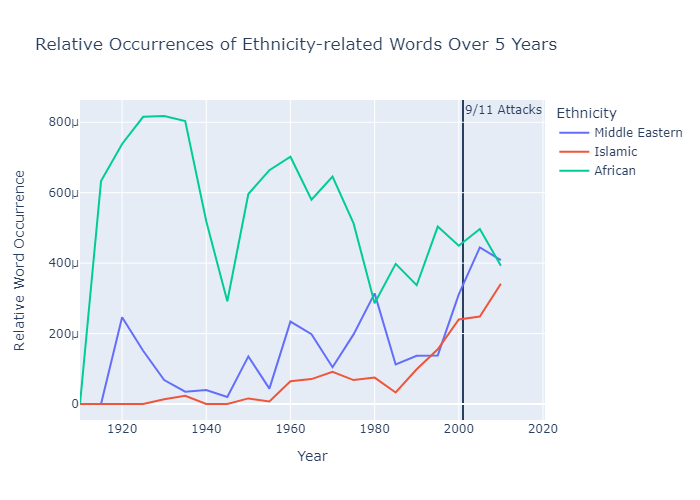

In [34]:
ethnicities=["Middle Eastern",'Islamic','African']
plot_relative_occurrences(df_sum, ethmerged, ethnicities, 5, [('2001', '2001', '9/11 Attacks')]).show(renderer="png")

This is similar to what we saw for other events.

We choose to focus on historical event involving the USA because for the time period of our dataset, the USA were the main producers of movies. Indeed, it seems like big events for other countries do not create the same reaction spike, like this example.

Overall, we would like to dive deeper into the increase of representation after a big event as well as the first spike in popularity.

In [22]:
def plot_relative_centered(df, eth, ethnicities, period=5, highlight_periods=None):
    data = df.copy()

    for et in ethnicities:
        index = eth[eth['Ethnicity'] == et].index[0]
        occ_list = literal_eval(eth.at[index, 'Keywords'])

        def count_words(word_list):
            return sum(word.lower() in occ_list for word in word_list)

        # Apply the function to count ethnicity-related words for each row
        data[et] = data['tokens'].apply(lambda x: count_words(x))

    # Group by release year and sum the counts
    data['release_period'] = data['release_date'] // period * period
    counts_by_period = data.groupby('release_period')[ethnicities].sum().reset_index()

    # Normalize by the total number of words in each period
    total_words_by_period = data.groupby('release_period')['tokens'].apply(lambda x: sum(len(word_list) for word_list in x)).reset_index()
    counts_by_period = pd.merge(counts_by_period, total_words_by_period, on='release_period', how='left')

    for et in ethnicities:
        counts_by_period[et] = counts_by_period[et] / counts_by_period['tokens']

    # Convert the DataFrame to long format for Plotly
    counts_by_period_long = pd.melt(counts_by_period, id_vars='release_period', value_vars=ethnicities)

    # Create a stacked area plot using Plotly Express
    fig = px.area(counts_by_period_long, x='release_period', y='value', color='variable',
                 title='Relative Occurrences of Ethnicity-related Words Over the Years',
                 labels={'value': 'Relative Occurrences', 'variable': 'Ethnicity'},
                 category_orders={'variable': ethnicities})

    if highlight_periods:
        for period_range in highlight_periods:
            fig.add_vrect(
                x0=period_range[0],
                x1=period_range[1],
                annotation_text=period_range[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.3)', 
                layer='below',
                line=None)
    fig.update_xaxes(range=[int(period_range[0])-20, int(period_range[0])+40])
    return fig


In [23]:
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

figures = [
plot_relative_occurrences(df_sum, ethmerged, ['German','Nazi','Japanese',],1),
plot_relative_occurrences(df_sum, ethmerged, ['French','Spanish','American'], 1,)   
]

fig = make_subplots(rows=len(figures), cols=1) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

for dates in [
    ('1914', '1918', 'WWI'),
    ('1939', '1945', 'WWII'),
    ('1989', '1989', 'Fall of the Berlin Wall')
             ]:
    fig.add_vrect(
                x0=dates[0],
                x1=dates[1],
                annotation_text=dates[2],
                annotation_position="top left",
                fillcolor='rgba(255, 0, 0, 0.05)', 
                layer='below',
                line=None)

#fig_json = fig.to_json()

#with open('figures/ethnicity-representation.json', 'w') as json_file:
#    json.dump(json.loads(fig_json), json_file, indent=4)   

fig.show()

In [24]:
data_window = get_relative_occurrences(df_sum, ethmerged, ['German'], period=1)

In [25]:
data_window

,release_period,variable,value
0,1910.0,German,0.000000
1,1911.0,German,0.000000
2,1912.0,German,0.000000
3,1913.0,German,0.000558
4,1914.0,German,0.000000
...,...,...,...
100,2010.0,German,0.000340
101,2011.0,German,0.000648
102,2012.0,German,0.000409
103,2013.0,German,0.002028


In [26]:
def get_anomalies(data_window):
    import pandas as pd
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import StandardScaler

    values = data_window['value'].values.reshape(-1, 1)  # Reshaping the data to a 2D array

    scaler = StandardScaler()
    data_window['standardized_value'] = scaler.fit_transform(values)

    # Fit the Isolation Forest model
    model = IsolationForest(n_estimators=5, contamination=0.005, random_state=42)
    # Predict anomalies - fit_predict expects a 2D array
    data_window['anomaly'] = model.fit_predict(data_window[['standardized_value']])

    # Convert the anomaly numbers to boolean flags (True for anomalies, False for normal points)
    data_window['anomaly'] = data_window['anomaly'] == -1

    # Filter the anomalies
    anomalies = data_window[data_window['anomaly']]
    return anomalies


In [27]:
d = get_relative_occurrences(df_sum, ethmerged, ['Vietnamese'], period=1)
get_anomalies(d)

,release_period,variable,value,standardized_value,anomaly
78,1988.0,Vietnamese,0.000753,3.050558,True


In [28]:
d = get_relative_occurrences(df_sum, ethmerged, ['Japanese'], period=1)
get_anomalies(d)

,release_period,variable,value,standardized_value,anomaly
33,1943.0,Japanese,0.005376,6.110745,True


In [29]:
d = get_relative_occurrences(df_sum, ethmerged, ['German'], period=1)
get_anomalies(d)

,release_period,variable,value,standardized_value,anomaly
33,1943.0,German,0.006658,4.616883,True


In [30]:
d = get_relative_occurrences(df_sum, ethmerged, ['German'], period=1)
window_jap = get_anomalies_window(d)
window_jap

,start_date,end_date,release_date_window
group,,,
2,1920.0,1920.0,[1920.0]
4,1944.0,1945.0,"[1944.0, 1945.0]"


In [31]:
import scipy.stats as stats
d = get_relative_occurrences(df_sum, ethmerged, ['German'], period=1)
print(np.std(d['value']))
d['zscore'] = stats.zscore(d.value)
d.loc[d['zscore'] >= 2]

0.0011968318615882692


,release_period,variable,value,zscore
6,1916.0,German,0.006114,4.162143
7,1917.0,German,0.005766,3.871866
8,1918.0,German,0.005140,3.348019
33,1943.0,German,0.006658,4.616883


In [32]:

px.histogram(d.value)

In [33]:
list = np.array([1,1,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0.7,0,0,0,])
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=10, contamination=0.01, random_state=42)
model.fit_predict(list.reshape(-1, 1))

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

Function Definition: The function get_anomalies_window takes a DataFrame data_window as input, which is expected to contain the time series data.

Importing Necessary Libraries:

pandas for data manipulation.
IsolationForest from scikit-learn for anomaly detection.
StandardScaler from scikit-learn for standardizing the data.
numpy for numerical operations.
Setting the Window Size: window_size is defined, which specifies the number of data points to be considered in each rolling window. This is used later to calculate the rolling average of anomaly scores.

Data Reshaping:

The values from the 'value' column of data_window are extracted and reshaped into a two-dimensional array, which is necessary for compatibility with scikit-learn's Isolation Forest model.
Standardization of Features:

The values are standardized using StandardScaler. This process scales the data so that it has a mean of 0 and a standard deviation of 1, which is often beneficial for machine learning algorithms.
Isolation Forest Model:

An Isolation Forest model is instantiated and fitted to the standardized data.
The decision_function method of the model is used to compute the anomaly scores for each data point. The scores essentially measure how "isolated" or "anomalous" a data point is.
Rolling Score Calculation:

A rolling average of these anomaly scores is computed over the specified window_size. This rolling score helps to smooth out the scores over time and focus on windows of data rather than individual points.
Anomaly Threshold Determination:

A threshold is set to identify anomaly windows. In this case, it's set as the 1st percentile (quantile 0.01) of the rolling scores, meaning the lowest 1% of the rolling scores will be flagged as anomalies.
Grouping Consecutive Anomalies:

The function then identifies consecutive data points that are below the anomaly threshold.
It assigns a unique group number to each set of consecutive anomalies using a cumulative sum (cumsum) on the condition of whether a point is an anomaly or not.
Characterizing Anomaly Windows:

The function groups the anomalies and calculates the start and end of each anomaly window, as well as lists all the release periods within each window.
This is done by aggregating the minimum (start date) and maximum (end date) values of the 'release_period' within each group of consecutive anomalies. Additionally, it compiles a list of all 'release_period' values in each anomaly window.
Returning Anomaly Windows:

The function finally returns a DataFrame, anomaly_windows, which contains the start and end dates of each detected anomaly window, along with the list of release periods that fall within each window.
The purpose of this function is to not only detect anomalies in time series data but also to identify periods where these anomalies are concentrated, providing a more holistic view of anomalous behavior over time.